In [9]:
# 1.1 Install Python deps
!pip install ultralytics huggingface_hub pdf2image pillow matplotlib

# 1.2 Install poppler (needed by pdf2image)
!apt-get update -qq && apt-get install -y -qq poppler-utils

# 0) install Tesseract + its Python wrapper
!apt-get update -qq && apt-get install -y -qq tesseract-ocr
!pip install pytesseract


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
from pdf2image import convert_from_path
from PIL import Image
import os
import shutil

# where your downscaled pages will go
out_folder = '/content/pages'

# delete if it already exists
if os.path.exists(out_folder):
    shutil.rmtree(out_folder)
os.makedirs(out_folder, exist_ok=True)


from pdf2image import convert_from_path
import os

# output folder for the 500 pages
out_folder = '/content/pages'
# delete if it already exists
if os.path.exists(out_folder):
    shutil.rmtree(out_folder)
os.makedirs(out_folder, exist_ok=True)

# tweak dpi up/down for speed vs. quality
pages = convert_from_path("/content/OOP_Handouts_22-08-2009.pdf", dpi=200)

for i, page in enumerate(pages, start=1):
    png_path = os.path.join(out_folder, f'page_{i:03d}.png')
    page.save(png_path, 'PNG')

print(f"✅ Saved {len(pages)} pages to {out_folder}")

✅ Saved 349 pages to /content/pages


In [3]:
from huggingface_hub import snapshot_download
import os

repo_id = 'hantian/yolo-doclaynet'
local_dir = snapshot_download(repo_id, repo_type='model')
# pick the .pt file in the repo
weights = next(f for f in os.listdir(local_dir) if f.endswith('.pt'))
weights_path = os.path.join(local_dir, weights)

print("✅ Weights downloaded to:", weights_path)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

✅ Weights downloaded to: /root/.cache/huggingface/hub/models--hantian--yolo-doclaynet/snapshots/d7152ba405ed78e7e8a5769abf72c31768a15bb4/yolov10s-doclaynet.pt



image 1/1 /content/pages/page_001.png: 1024x800 2 Page-footers, 2 Page-headers, 1 Section-header, 1 Text, 1 Title, 61.6ms
Speed: 24.6ms preprocess, 61.6ms inference, 86.1ms postprocess per image at shape (1, 3, 1024, 800)

image 1/1 /content/pages/page_002.png: 1024x800 2 Page-footers, 2 Page-headers, 1 Table, 27.7ms
Speed: 10.5ms preprocess, 27.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 800)

image 1/1 /content/pages/page_003.png: 1024x800 2 Page-footers, 2 Page-headers, 1 Table, 27.5ms
Speed: 9.9ms preprocess, 27.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 800)

image 1/1 /content/pages/page_004.png: 1024x800 2 Page-footers, 2 Page-headers, 1 Table, 27.6ms
Speed: 10.3ms preprocess, 27.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 800)

image 1/1 /content/pages/page_005.png: 1024x800 2 Page-footers, 2 Page-headers, 1 Table, 27.6ms
Speed: 10.6ms preprocess, 27.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1024,

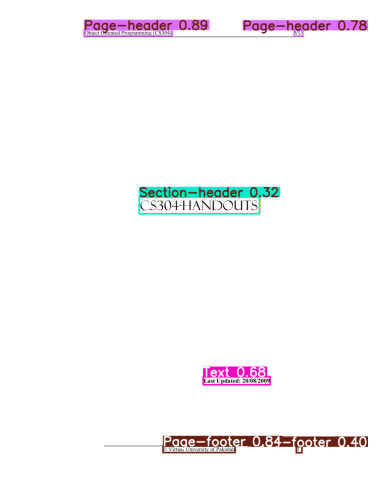

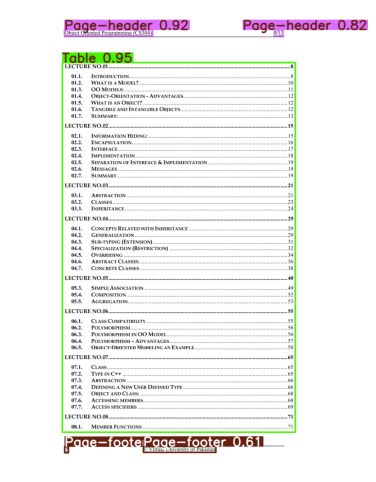

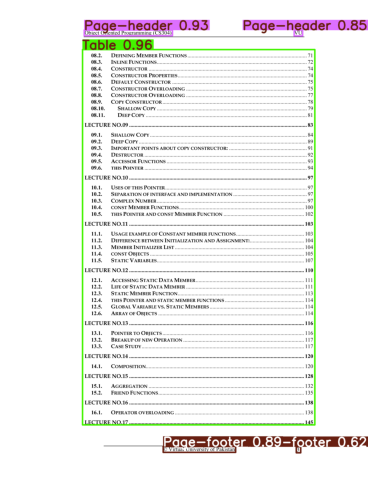

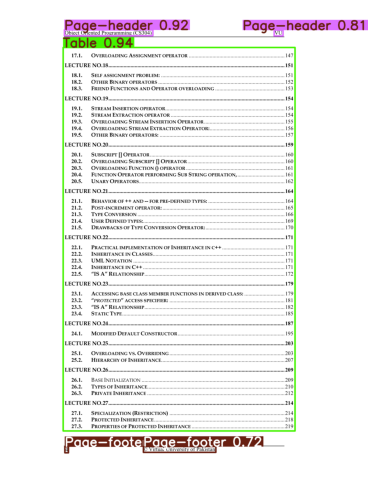

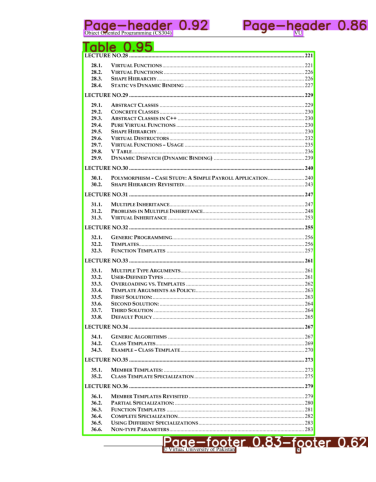

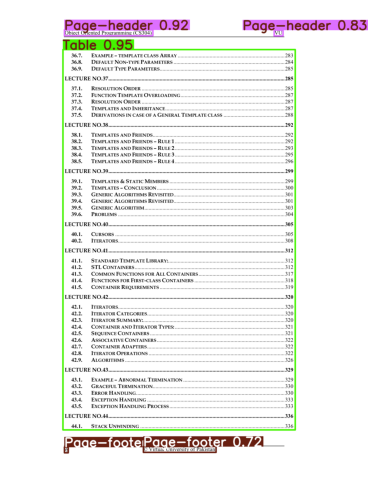

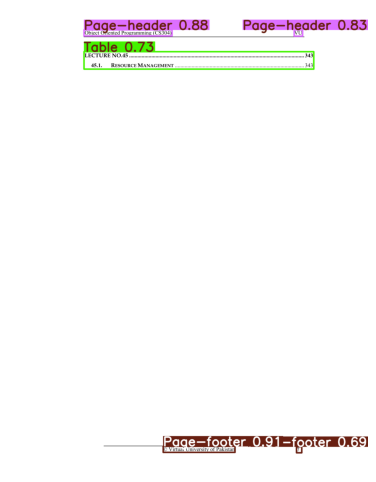

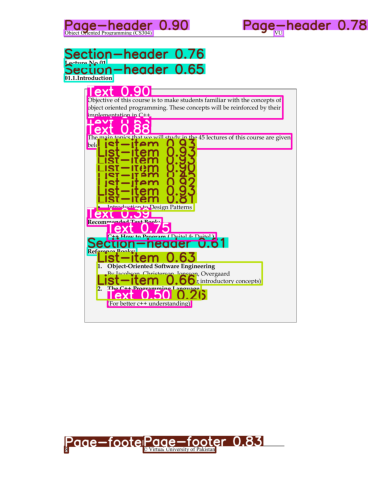

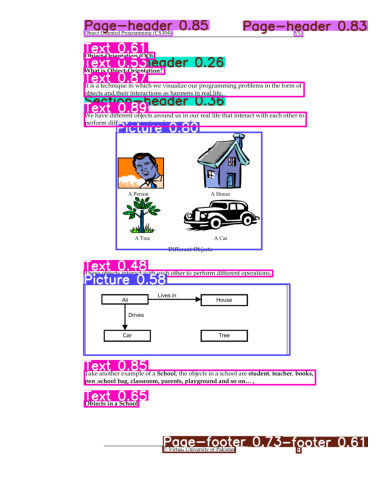

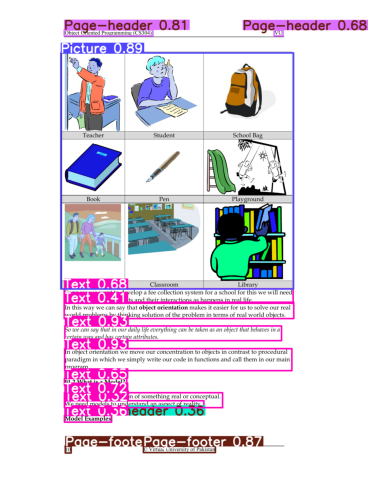

In [4]:
from ultralytics import YOLO
import glob
import matplotlib.pyplot as plt

# load model
model = YOLO(weights_path)

# pick first N pages to test (or remove [:N] to do them all)
pngs = sorted(glob.glob('/content/pages/*.png'))[:10]

for img_path in pngs:
    # run one image (you can also batch with model.predict)
    result = model(img_path)[0]

    # .plot() returns a numpy array with boxes/labels drawn
    annotated = result.plot()

    # display inline
    plt.figure(figsize=(6,6))
    plt.imshow(annotated)
    plt.axis('off')


In [7]:
names = model.names
names

{0: 'Caption',
 1: 'Footnote',
 10: 'Title',
 2: 'Formula',
 3: 'List-item',
 4: 'Page-footer',
 5: 'Page-header',
 6: 'Picture',
 7: 'Section-header',
 8: 'Table',
 9: 'Text'}

In [ ]:
import glob
import gc
import torch
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

# load your model (make sure weights_path is defined)
model = YOLO(weights_path).to('cuda:0').half()

# gather your (downscaled) page images
img_paths = sorted(glob.glob('/content/pages/*.[pj][pn]g'))  # matches .png/.jpg

if not img_paths:
    raise RuntimeError("No images found in /content/pages!")

# helper to clear GPU between pages
def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()

# loop pages
for page_idx, img_path in enumerate(img_paths, start=1):
    print(f"\n\n🔖 Page {page_idx}\n" + ("─" * 20))
    img = Image.open(img_path)

    # stream through each detection on this single page
    for res in model.predict(source=img_path,
                             device='cuda:0',
                             batch=1,
                             half=True,
                             imgsz=640,
                             stream=True):
        # get boxes & class IDs
        boxes = res.boxes.xyxy.cpu().numpy()      # shape (N,4)
        cls_ids = res.boxes.cls.cpu().numpy().astype(int)

        # collect only text‑bearing classes
        items = []
        for (x1,y1,x2,y2), cid in zip(boxes, cls_ids):
            name = model.names[cid]
            if name.lower() == 'picture':
                continue
            items.append((y1, name, (x1,y1,x2,y2)))

        # sort by top of box (y1)
        items.sort(key=lambda it: it[0])

        # OCR & display each
        for _, name, (x1,y1,x2,y2) in items:
            crop = img.crop((x1, y1, x2, y2))
            text = pytesseract.image_to_string(crop).strip()

            # show the cropped region
            plt.figure(figsize=(4,4))
            plt.imshow(crop)
            plt.axis('off')

            # print metadata + OCR
            print(f"• Class: {name}")
            print(f"  Box: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")
            print(f"  OCR → {repr(text)}\n")

    # free GPU before next page
    free_gpu()




🔖 Page 1
────────────────────

image 1/1 /content/pages/page_001.png: 640x512 2 Page-footers, 2 Page-headers, 1 Section-header, 1 Text, 1 Title, 118.2ms
• Class: Page-header
  Box: (347.6, 94.2, 765.3, 123.1)
  OCR → 'Object Oriented Programming (CS304)'

• Class: Page-header
  Box: (1348.4, 95.1, 1388.8, 121.8)
  OCR → 'VU'

• Class: Section-header
  Box: (609.3, 892.9, 1189.4, 967.7)
  OCR → 'CS304-HANDOUTS'

• Class: Title
  Box: (610.2, 892.9, 1189.4, 967.7)
  OCR → 'CS304-HANDOUTS'

• Class: Text
  Box: (914.4, 1750.5, 1234.9, 1780.6)
  OCR → 'Last Updated: 20/08/2009'

• Class: Page-footer
  Box: (719.3, 2078.0, 1071.6, 2105.5)
  OCR → '© Virtual University of Pakistan'

• Class: Page-footer
  Box: (1353.5, 2078.0, 1382.7, 2110.6)
  OCR → ''

Speed: 4.5ms preprocess, 118.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


🔖 Page 2
────────────────────

image 1/1 /content/pages/page_002.png: 640x512 2 Page-footers, 2 Page-headers, 1 Table, 17.1ms
• Class: Page

/tmp/ipython-input-10-3326151693.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,4))


Streaming output truncated to the last 5000 lines.
  Box: (348.9, 202.0, 1442.9, 307.7)
  OCR → 'Rule 4 says that when we declare a template as friend of any class then all kinds\nspecializations of that function - explicit, implicit and partial, also becomes friends of\nthe class granting friendship.'

• Class: Text
  Box: (348.5, 346.5, 597.7, 414.4)
  OCR → 'template< class T >\nclass B {'

• Class: Text
  Box: (348.0, 346.5, 597.7, 378.1)
  OCR → 'template< class T >'

• Class: Text
  Box: (348.5, 384.4, 452.5, 414.0)
  OCR → 'class B }'

• Class: Text
  Box: (446.9, 421.1, 534.5, 449.5)
  OCR → 'data;'

• Class: Text
  Box: (443.4, 456.3, 701.7, 483.8)
  OCR → 'template< class U >'

• Class: Text
  Box: (353.4, 524.6, 452.9, 554.7)
  OCR → '(Rule 3)'

• Class: Section-header
  Box: (352.8, 525.1, 452.9, 555.2)
  OCR → '(Rule 3)'

• Class: Text
  Box: (350.6, 562.5, 370.4, 595.1)
  OCR → ''

• Class: Text
  Box: (350.0, 629.9, 602.9, 661.3)
  OCR → 'template< class U >'

• Class: T

In [5]:
# 1) imports & globals
import glob, gc, json, os, torch, pytesseract
from PIL import Image
from ultralytics import YOLO
from concurrent.futures import ThreadPoolExecutor, as_completed

# where your pages live
IMG_DIR = '/content/pages'
CHECKPOINT = 'segments_checkpoint.json'

# load & half‑precision the model on GPU
model = YOLO(weights_path).to('cuda:0').half()

# gather images (png/jpg)
img_paths = sorted(glob.glob(os.path.join(IMG_DIR, '*.[pj][pn]g')))
if not img_paths:
    raise RuntimeError("No images found in " + IMG_DIR)

# helper to free GPU
def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()

# OCR worker (thread‐safe since pytesseract calls an external binary)
def ocr_segment(img_path, page, cls, bbox):
    x1,y1,x2,y2 = map(int, bbox)
    crop = Image.open(img_path).crop((x1,y1,x2,y2))
    txt  = pytesseract.image_to_string(crop).strip()
    return {
        'page': page,
        'class': cls,
        'bbox': [x1,y1,x2,y2],
        'text': txt
    }

# main loop
segments = []  # will hold all your dicts

# choose number of threads equal to (say) half your cores
n_threads = max(1, os.cpu_count() // 2)

for idx, img_path in enumerate(img_paths, start=1):
    print(f"\n🔖 Page {idx}/{len(img_paths)}")

    # 1) YOLO detect (stream) on this one page
    detections = model.predict(
        source=[img_path],
        device='cuda:0',
        imgsz=640,
        half=True,
        batch=1,
        stream=True
    )

    # 2) build a small list of (page, class, bbox) for OCR
    tasks = []
    for res in detections:
        boxes = res.boxes.xyxy.cpu().numpy()
        clsids= res.boxes.cls.cpu().numpy().astype(int)
        for bbox, cid in zip(boxes, clsids):
            cls_name = model.names[cid]
            if cls_name.lower() == 'picture':
                continue
            tasks.append((img_path, idx, cls_name, bbox))

    # 3) OCR them in parallel
    with ThreadPoolExecutor(max_workers=n_threads) as exe:
        futures = [exe.submit(ocr_segment, *t) for t in tasks]
        for f in as_completed(futures):
            segments.append(f.result())

    # 4) checkpoint every 50 pages
    if idx % 50 == 0:
        with open(CHECKPOINT, 'w') as f:
            json.dump(segments, f, indent=2)
        print(f"→ checkpointed {len(segments)} segments to {CHECKPOINT}")

    # 5) free GPU
    free_gpu()

# final save
with open('all_segments.json', 'w') as f:
    json.dump(segments, f, indent=2)
print("✅ Done! Total segments:", len(segments))


🔖 Page 1/349

0: 640x512 2 Page-footers, 2 Page-headers, 1 Section-header, 1 Text, 1 Title, 75.0ms
Speed: 4.4ms preprocess, 75.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

🔖 Page 2/349

0: 640x512 2 Page-footers, 2 Page-headers, 1 Table, 10.3ms
Speed: 3.4ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

🔖 Page 3/349

0: 640x512 2 Page-footers, 2 Page-headers, 1 Table, 11.2ms
Speed: 3.2ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

🔖 Page 4/349

0: 640x512 2 Page-footers, 2 Page-headers, 1 Table, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

🔖 Page 5/349

0: 640x512 2 Page-footers, 2 Page-headers, 1 Table, 24.8ms
Speed: 5.6ms preprocess, 24.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)

🔖 Page 6/349

0: 640x512 2 Page-footers, 2 Page-headers, 1 Table, 10.7ms
Speed: 3.2ms preprocess, 10.7ms inference, 0.

In [8]:
# remove the legacy package
!pip uninstall -y pinecone-client

# install the new SDK
!pip install --upgrade pinecone


# !pip install pinecone-client sentence-transformers

Found existing installation: pinecone-client 6.0.0
Uninstalling pinecone-client-6.0.0:
  Successfully uninstalled pinecone-client-6.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 23.9 MB/s eta 0:00:00


In [12]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(
    api_key="insert-key-here",
    environment="us-east1-aws"       # US East (AWS) for serverless
)

if INDEX_NAME not in pc.list_indexes().names():
    pc.create_index(
        name=INDEX_NAME,
        dimension=DIMENSION,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
index = pc.Index(INDEX_NAME)


In [13]:
from sentence_transformers import SentenceTransformer

# 3.1—Load a small embedder
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# 3.2—Collect all texts
texts = [seg["text"] for seg in segments]

# 3.3—Compute embeddings in one go (or in batches)
vectors = embedder.encode(
    texts,
    show_progress_bar=True,
    convert_to_numpy=True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/215 [00:00<?, ?it/s]

In [17]:
# ---------------------------------------------------
# 4.1 — Choose a batch size
BATCH_SIZE = 50

# 4.2 — Loop and upsert into Pinecone,
#       now including the OCR’d text in metadata
for i in range(0, len(segments), BATCH_SIZE):
    # slice out this batch of segments + their embeddings
    chunk_segs = segments[i : i + BATCH_SIZE]
    chunk_vecs = vectors[i : i + BATCH_SIZE]

    # prepare the upsert payload
    to_upsert = []
    for j, seg in enumerate(chunk_segs):
        # build a unique ID for this segment
        uid = f"p{int(seg['page'])}_s{i + j}"

        # metadata now includes page, class, bbox coords, AND text
        metadata = {
            "page":  int(seg["page"]),
            "class": seg["class"],
            "x1":    float(seg["bbox"][0]),
            "y1":    float(seg["bbox"][1]),
            "x2":    float(seg["bbox"][2]),
            "y2":    float(seg["bbox"][3]),
            "text":  seg["text"],
        }

        # vector must be a plain Python list
        vector = chunk_vecs[j].tolist()

        # append a tuple of (id, vector, metadata)
        to_upsert.append((uid, vector, metadata))

    # perform the upsert
    index.upsert(vectors=to_upsert)
    print(f"Upserted batch {i // BATCH_SIZE + 1} of "
          f"{(len(segments) + BATCH_SIZE - 1) // BATCH_SIZE}")

print("✅ All segments upserted!")

Upserted batch 1 of 138
Upserted batch 2 of 138
Upserted batch 3 of 138
Upserted batch 4 of 138
Upserted batch 5 of 138
Upserted batch 6 of 138
Upserted batch 7 of 138
Upserted batch 8 of 138
Upserted batch 9 of 138
Upserted batch 10 of 138
Upserted batch 11 of 138
Upserted batch 12 of 138
Upserted batch 13 of 138
Upserted batch 14 of 138
Upserted batch 15 of 138
Upserted batch 16 of 138
Upserted batch 17 of 138
Upserted batch 18 of 138
Upserted batch 19 of 138
Upserted batch 20 of 138
Upserted batch 21 of 138
Upserted batch 22 of 138
Upserted batch 23 of 138
Upserted batch 24 of 138
Upserted batch 25 of 138
Upserted batch 26 of 138
Upserted batch 27 of 138
Upserted batch 28 of 138
Upserted batch 29 of 138
Upserted batch 30 of 138
Upserted batch 31 of 138
Upserted batch 32 of 138
Upserted batch 33 of 138
Upserted batch 34 of 138
Upserted batch 35 of 138
Upserted batch 36 of 138
Upserted batch 37 of 138
Upserted batch 38 of 138
Upserted batch 39 of 138
Upserted batch 40 of 138
Upserted 

In [26]:
query_embedding = embedder.encode("What is the core concept of encapsulation? Not advantages", convert_to_numpy=True)
response = index.query(
    vector=query_embedding.tolist(),
    top_k=10,
    include_metadata=True
)
for match in response["matches"]:
    print(match["score"], match["metadata"], match["id"])

0.9263466 {'class': 'Section-header', 'page': 17.0, 'text': 'Advantages of Encapsulation', 'x1': 397.0, 'x2': 791.0, 'y1': 1240.0, 'y2': 1277.0} p17_s228
0.9263466 {'class': 'Text', 'page': 17.0, 'text': 'Advantages of Encapsulation', 'x1': 397.0, 'x2': 791.0, 'y1': 1240.0, 'y2': 1277.0} p17_s229
0.923654139 {'class': 'Text', 'page': 17.0, 'text': 'The following are the main advantages of Encapsulation,', 'x1': 400.0, 'x2': 1131.0, 'y1': 1278.0, 'y2': 1313.0} p17_s212
0.795047522 {'class': 'Text', 'page': 16.0, 'text': 'Encapsulation means “we have enclosed all the characteristics of an object in the object\nitself”', 'x1': 303.0, 'x2': 1346.0, 'y1': 1124.0, 'y2': 1193.0} p16_s190
0.787059426 {'class': 'Text', 'page': 16.0, 'text': 'Examples of Encapsulation', 'x1': 301.0, 'x2': 668.0, 'y1': 1514.0, 'y2': 1552.0} p16_s199
0.787059426 {'class': 'Section-header', 'page': 16.0, 'text': 'Examples of Encapsulation', 'x1': 302.0, 'x2': 666.0, 'y1': 1514.0, 'y2': 1552.0} p16_s201
0.751790762 

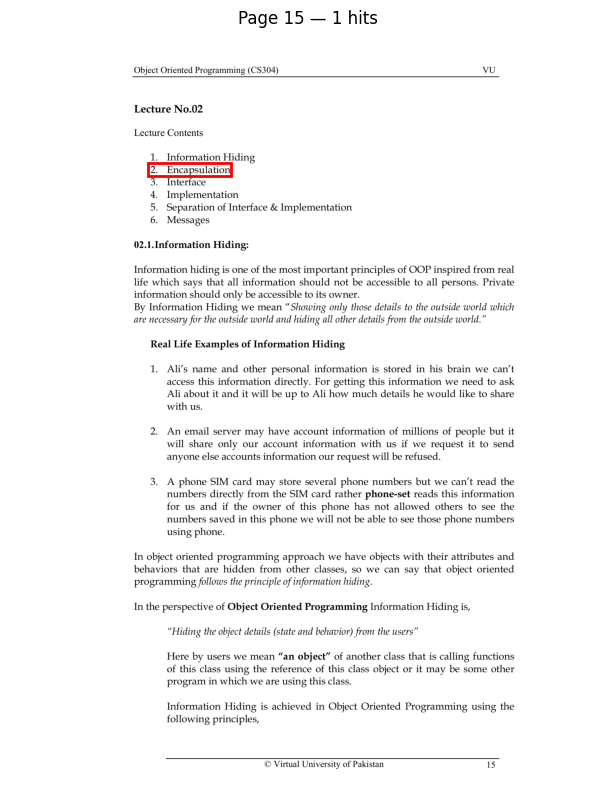

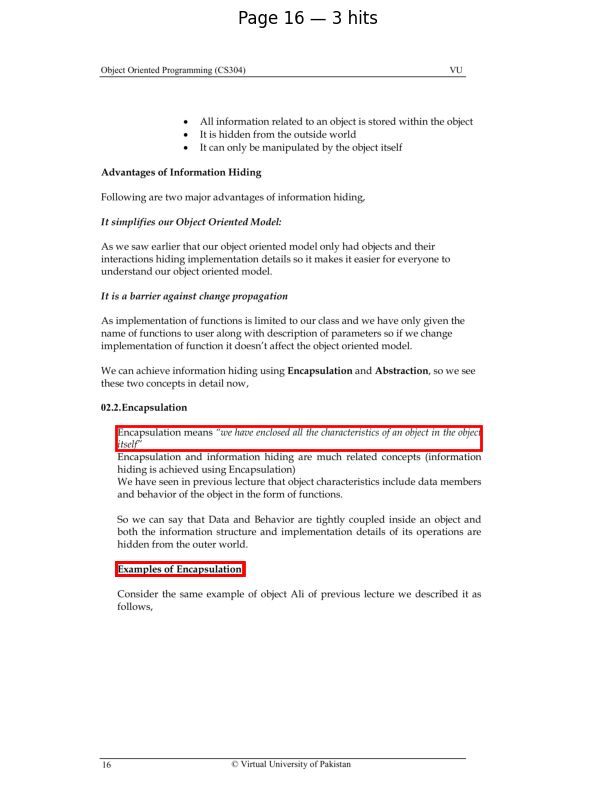

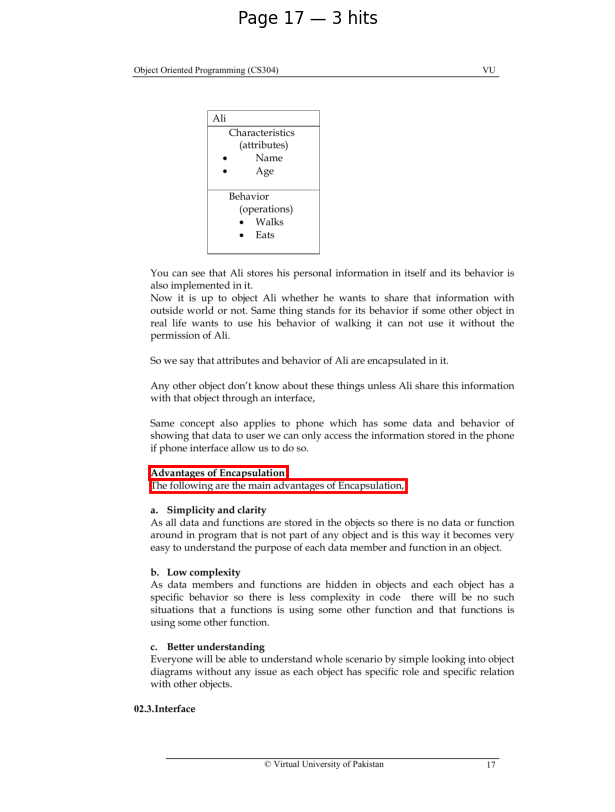

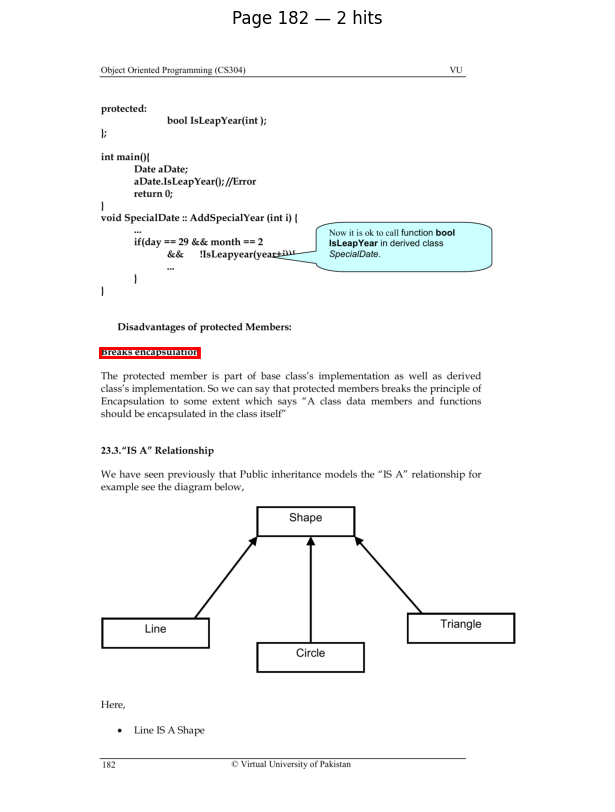

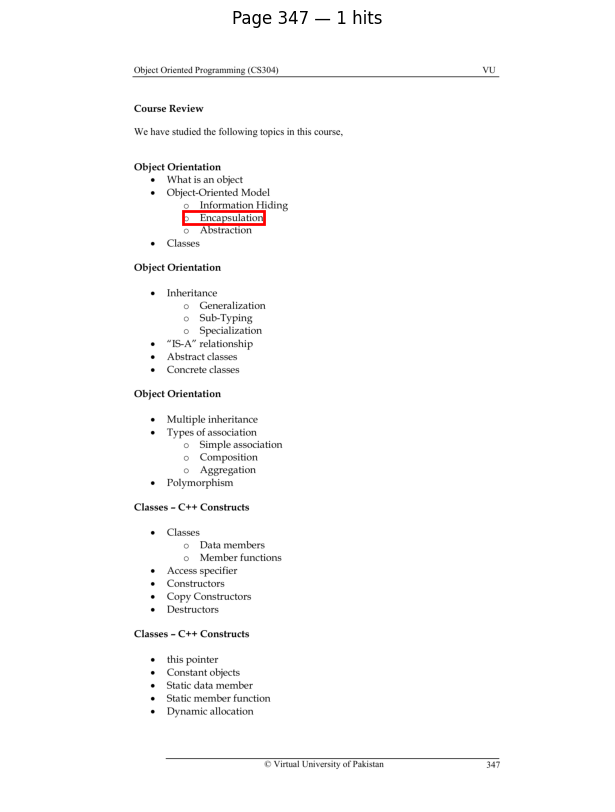

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from collections import defaultdict

# ── assume you already have:
# response = index.query(..., include_metadata=True)
# img_dir   = '/content/pages'

# 1) group matches by page
page_to_matches = defaultdict(list)
for match in response["matches"]:
    meta = match["metadata"]
    page = int(meta["page"])
    page_to_matches[page].append(meta)

# 2) for each page, draw all boxes
for page, metas in sorted(page_to_matches.items()):
    # load the page image
    img_path = f"pages/page_{page:03d}.png"
    img = Image.open(img_path)

    # setup figure
    fig, ax = plt.subplots(figsize=(8,10))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Page {page} — {len(metas)} hits")

    # draw each box
    for meta in metas:
        x1, y1 = meta["x1"], meta["y1"]
        x2, y2 = meta["x2"], meta["y2"]
        cls     = meta["class"]

        # rectangle
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

        # label
        # ax.text(
        #     x1, y1 - 5, cls,
        #     color='red',
        #     fontsize=12,
        #     weight='bold',
        #     backgroundcolor='white'
        # )

    plt.show()
